![digitizing_team](digitizing_team.png)


DigiNsure Inc. is an innovative insurance company focused on enhancing the efficiency of processing claims and customer service interactions. Their newest initiative is digitizing all historical insurance claim documents, which includes improving the labeling of some IDs scanned from paper documents and identifying them as primary or secondary IDs.

To help them in their effort, you'll be using multi-modal learning to train an Optical Character Recognition (OCR) model. To improve the classification, the model will use **images** of the scanned documents as input and their **insurance type** (home, life, auto, health, or other). Integrating different data modalities (such as image and text) enables the model to perform better in complex scenarios, helping to capture more nuanced information. The **labels** that the model will be trained to identify are of two types: a primary and a secondary ID, for each image-insurance type pair.

In [159]:
! pip install torchvision

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


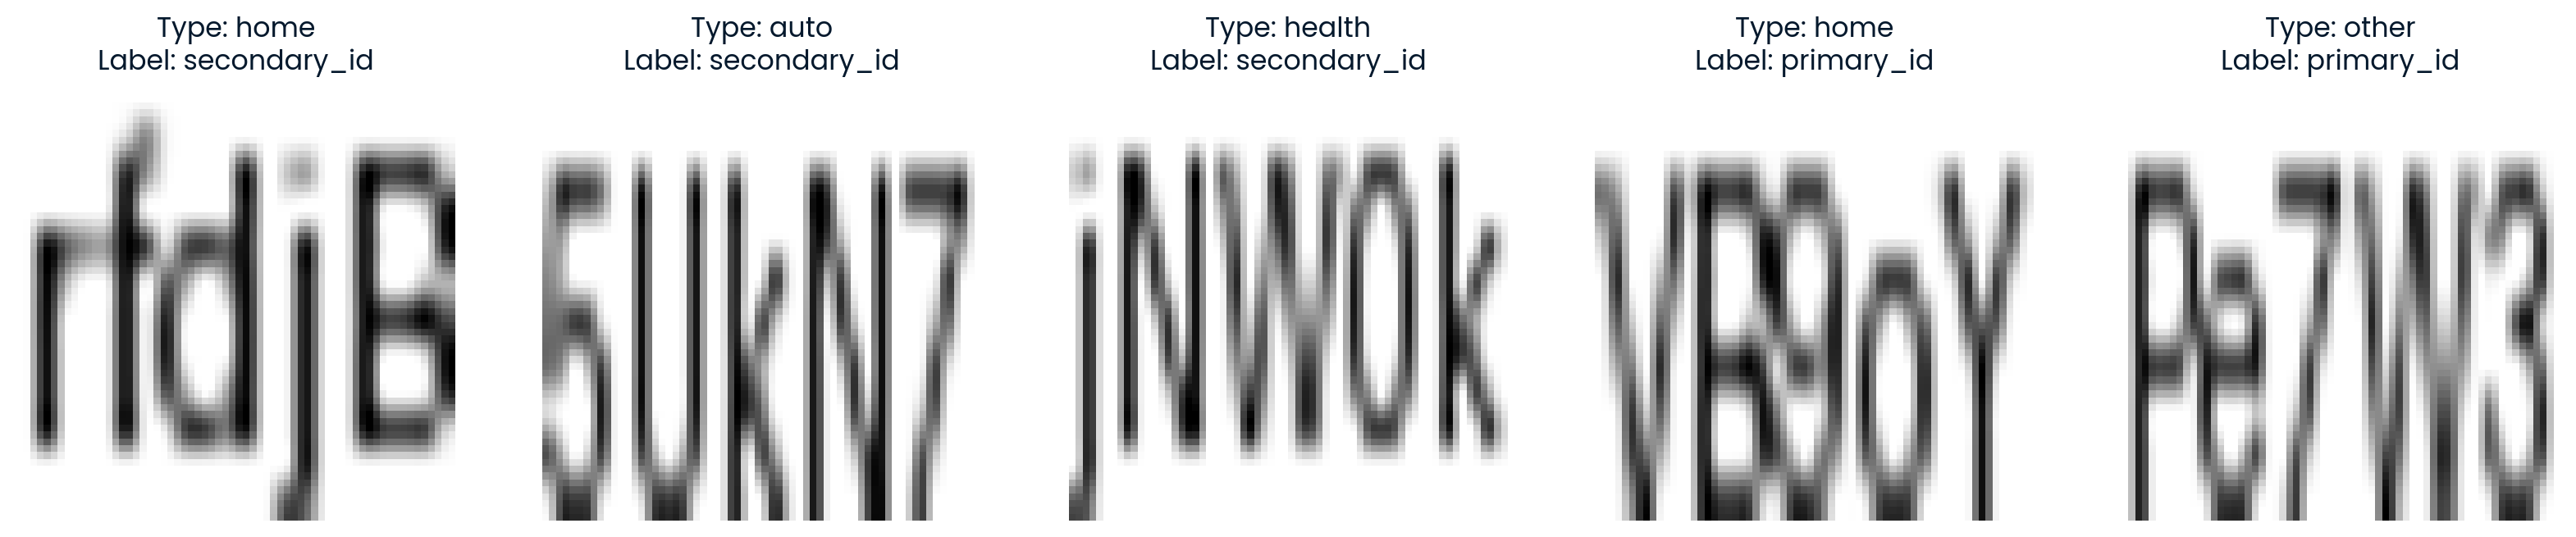

In [160]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from project_utils import ProjectDataset
import pickle 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Load the data
dataset = pickle.load(open('ocr_insurance_dataset.pkl', 'rb'))

# Define a function to visualize codes with their corresponding types and labels 
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset), min(num_images, len(dataset)), False)):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray'), ax.axis('off')
        ax.set_title(f"Type: {list(dataset.type_mapping.keys())[img[1].tolist().index(1)]}\nLabel: {list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]}")
    plt.show()

# Inspect 5 codes images from the dataset
show_dataset_images(dataset)

In [161]:
type(dataset)

project_utils.ProjectDataset

In [162]:
# •	This is a tuple of two elements:
# 1.	First element: A nested tuple containing:
# •	tensor([...]) → The image tensor.
# •	tensor([1., 0., 0., 0., 0.]) → A one-hot encoded label tensor.
# 2.	Second element: The integer label 0/1.
# unpacked as data, label = dataset[i]
print(dataset[0])

((tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.8824, 0.7804, 0.7373],
         [1.0000, 1.0000, 1.0000,  ..., 0.9176, 0.7961, 0.7451],
         [1.0000, 1.0000, 1.0000,  ..., 0.9373, 0.8039, 0.7451]]]), tensor([1., 0., 0., 0., 0.])), 0)


In [163]:
data, labels = dataset[0]
print(f"Images + insurance type:{data} \n \n Labels:{labels}")

Images + insurance type:(tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.8824, 0.7804, 0.7373],
         [1.0000, 1.0000, 1.0000,  ..., 0.9176, 0.7961, 0.7451],
         [1.0000, 1.0000, 1.0000,  ..., 0.9373, 0.8039, 0.7451]]]), tensor([1., 0., 0., 0., 0.])) 
 
 Labels:0


In [164]:
from torch.utils.data import Dataset
import torch.optim as optim
#from torchvision import transforms

Create Pytorch Dataset

In [165]:
class ProjectDatasetWrapper(Dataset):
    #def __init__(self, transform, project_dataset):
    def __init__(self, project_dataset):
        super().__init__()
        #self.transform = transform
        self.project_dataset = project_dataset  

    def __len__(self):
        return len(self.project_dataset)  # Total number of samples

    def __getitem__(self, idx):
        data, label = self.project_dataset[idx]  # Extract data and label
        
        img, ins_type = data  # Unpack the data tuple
        #class_index = torch.argmax(one_hot_label).item()  # Convert one-hot to class index
        
        return img, ins_type, label

In [166]:
# projectdataset = ProjectDatasetWrapper(
#     transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Resize((64,64))]),
#         project_dataset = dataset)

In [167]:
projectdataset = ProjectDatasetWrapper(dataset)

In [168]:
if isinstance(projectdataset, Dataset):
    print("This is a PyTorch dataset!")
else:
    print("This is NOT a PyTorch dataset.")

This is a PyTorch dataset!


In [169]:
# •	This is a tuple of three separate elements:
# 1.	tensor([...]) → The image tensor.
# 2.	tensor([1., 0., 0., 0., 0.]) → The one-hot encoded label tensor.
# 3.	0 → An integer label.
# unpacked as image, label, extra = dataset[i]
print(projectdataset[0])

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.8824, 0.7804, 0.7373],
         [1.0000, 1.0000, 1.0000,  ..., 0.9176, 0.7961, 0.7451],
         [1.0000, 1.0000, 1.0000,  ..., 0.9373, 0.8039, 0.7451]]]), tensor([1., 0., 0., 0., 0.]), 0)


In [170]:
images, ins_type, labels = projectdataset[0]
print(f"Images:{images} \n Insurance Type:{ins_type} \n Labels:{labels}")

Images:tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.8824, 0.7804, 0.7373],
         [1.0000, 1.0000, 1.0000,  ..., 0.9176, 0.7961, 0.7451],
         [1.0000, 1.0000, 1.0000,  ..., 0.9373, 0.8039, 0.7451]]]) 
 Insurance Type:tensor([1., 0., 0., 0., 0.]) 
 Labels:0


DataLoader

In [171]:
dataloader_train = DataLoader(projectdataset, batch_size=1, shuffle=True)

In [172]:
all_labels = []
all_ins_types = []

for images, ins_type, labels in dataloader_train:
    all_labels.append(labels.flatten())  # Ensure labels are 1D
    all_ins_types.append(torch.argmax(ins_type, dim=1))  # Convert one-hot to class indices

# Concatenate all labels and find unique values
unique_labels_all = torch.unique(torch.cat(all_labels))
print(f"Unique labels across the entire dataset: {unique_labels_all}")

unique_ins_types = torch.unique(torch.cat(all_ins_types))
print(f"Unique insurance types across the entire dataset: {unique_ins_types}")

Unique labels across the entire dataset: tensor([0, 1])
Unique insurance types across the entire dataset: tensor([0, 1, 2, 3, 4])


In [173]:
images, ins_type, labels = next(iter(dataloader_train))
print(f"Images:{images} \n Insurance Type:{ins_type} \n Labels:{labels}")

Images:tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]]) 
 Insurance Type:tensor([[0., 0., 0., 0., 1.]]) 
 Labels:tensor([1])


In [174]:
print(images.shape)

torch.Size([1, 1, 64, 64])


In [175]:
print(labels.shape)

torch.Size([1])


In [176]:
## prediction from model is tensor([[0.5055]] so the target labels need to be reshaped (as is done below)
print(labels.view(-1,1).float())

tensor([[1.]])


Define the 2-input model

In [177]:
class OCRModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Define sub-networks as sequential models
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(16*32*32, 128)
        )
        self.instype_layer = nn.Sequential(
            nn.Linear(5, 8),
            nn.ELU(), 
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 + 8, 1), 
            #nn.Sigmoid()
        )
        
    def forward(self, x_image, x_instype):
        # Pass the x_image and x_alphabet through appropriate layers
        x_image = self.image_layer(x_image)
        x_instype= self.instype_layer(x_instype)
        # Concatenate x_image and x_instype
        x = torch.cat((x_image, x_instype), dim=1)
        #return self.classifier(x)
        return nn.functional.sigmoid(self.classifier(x))

In [178]:
model = OCRModel()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(1):
    for img, ins_type, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = model(img, ins_type)
        loss = criterion(outputs, labels.view(-1,1).float())
        loss.backward()
        optimizer.step()